# Shor Code ESM

In [20]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, IBMQ
from qiskit.quantum_info import random_statevector, Statevector
from numpy import pi
from qiskit.tools.monitor import job_monitor
#IBMQ.enable_account('9ca92f99294968c8d883deea6f397c27fd7e904601a7fee44f61a0a525f10d25dbbdf6487fc5be871e59002f8f23045845f3693f35f130a1ac6ff8e84630c607')

from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
backend = AerSimulator()
from qiskit.visualization import plot_histogram
import random

## 1) Encode State
### a) Set a random vector

In [21]:
# set random vector
random_vector = random_statevector(2)
random_vector.draw('latex')

<IPython.core.display.Latex object>

In [22]:
print("Is random_vector normalized ? "+ str(random_vector.is_valid()))
p_0 = round(random_vector.probabilities()[0]*100,2)
p_1 = round(random_vector.probabilities()[1]*100,2)
print("P(M(q=0))="+str(p_0)+"%")
print("P(M(q=1))="+str(p_1)+"%")

Is random_vector normalized ? True
P(M(q=0))=96.13%
P(M(q=1))=3.87%


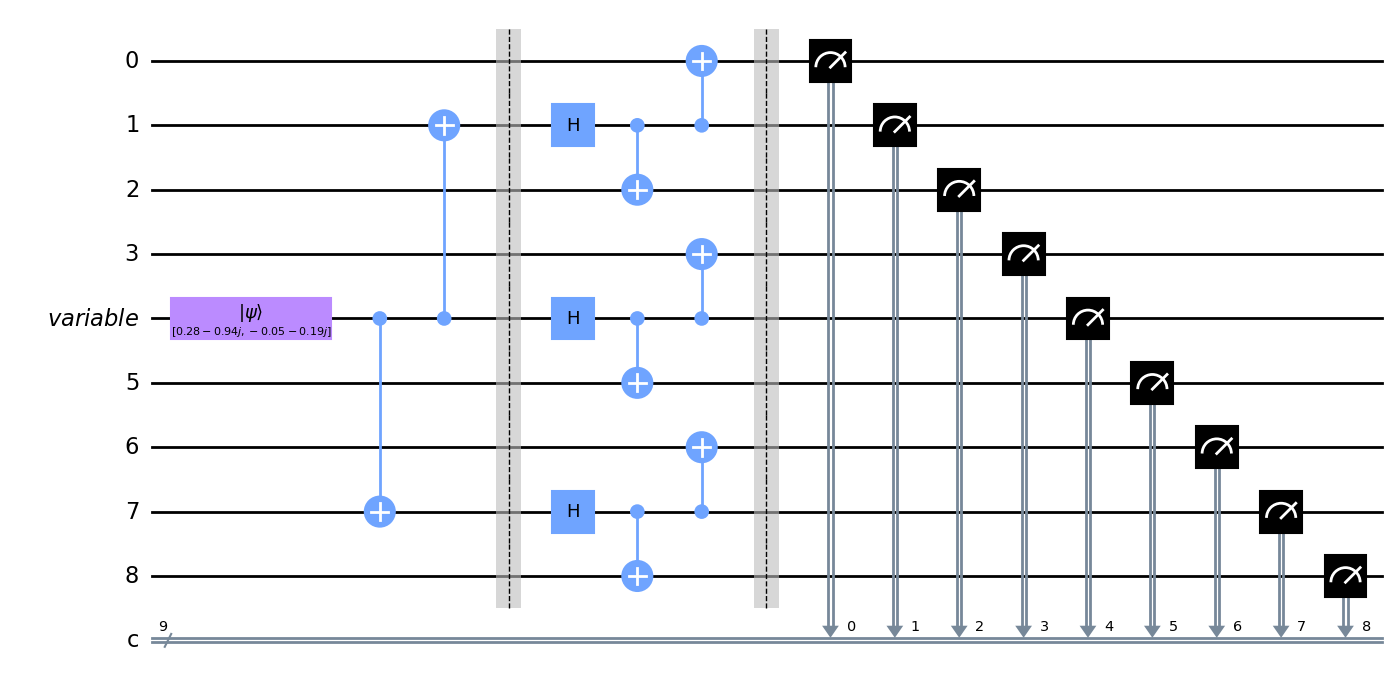

In [23]:
q_input = QuantumRegister(1, 'variable')
q = QuantumRegister(8, "q_")
test_c = ClassicalRegister(9, 'c')
test_circ = QuantumCircuit(q[:4], q_input, q[4:], test_c)

def test_barrier():
    test_circ.barrier(q[:4],q_input,q[4:])

test_circ.initialize(random_vector,4)

test_circ.cx(q_input[0], q[6])
test_circ.cx(q_input[0], q[1])
test_barrier()
test_circ.h(q[1])
test_circ.h(q_input[0])
test_circ.h(q[6])
test_circ.cx(q[1], q[2])
test_circ.cx(q_input[0], q[4])
test_circ.cx(q[6], q[7])
test_circ.cx(q[1], q[0])
test_circ.cx(q_input[0], q[3])
test_circ.cx(q[6], q[5])
test_barrier()
for i in range(9):
    test_circ.measure(i,test_c[i])


test_circ.draw('mpl')

{'111000000': 99, '111111111': 86, '111111000': 181, '000000000': 175, '111000111': 147, '000111000': 85, '000111111': 167, '000000111': 84}


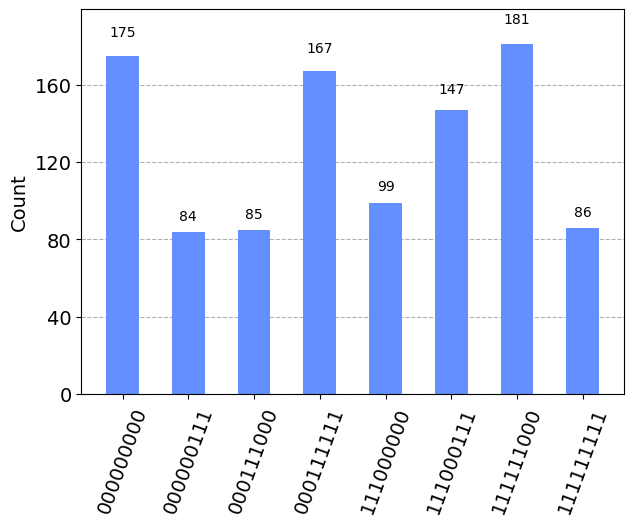

In [24]:
# First we have to transpile the quantum circuit
# to the low-level QASM instructions used by the
# backend
qc_compiled = transpile(test_circ, backend)

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend.run(qc_compiled, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)
plot_histogram(counts)


### b) Circuit Implementation

Introduced a X error on qubit_0


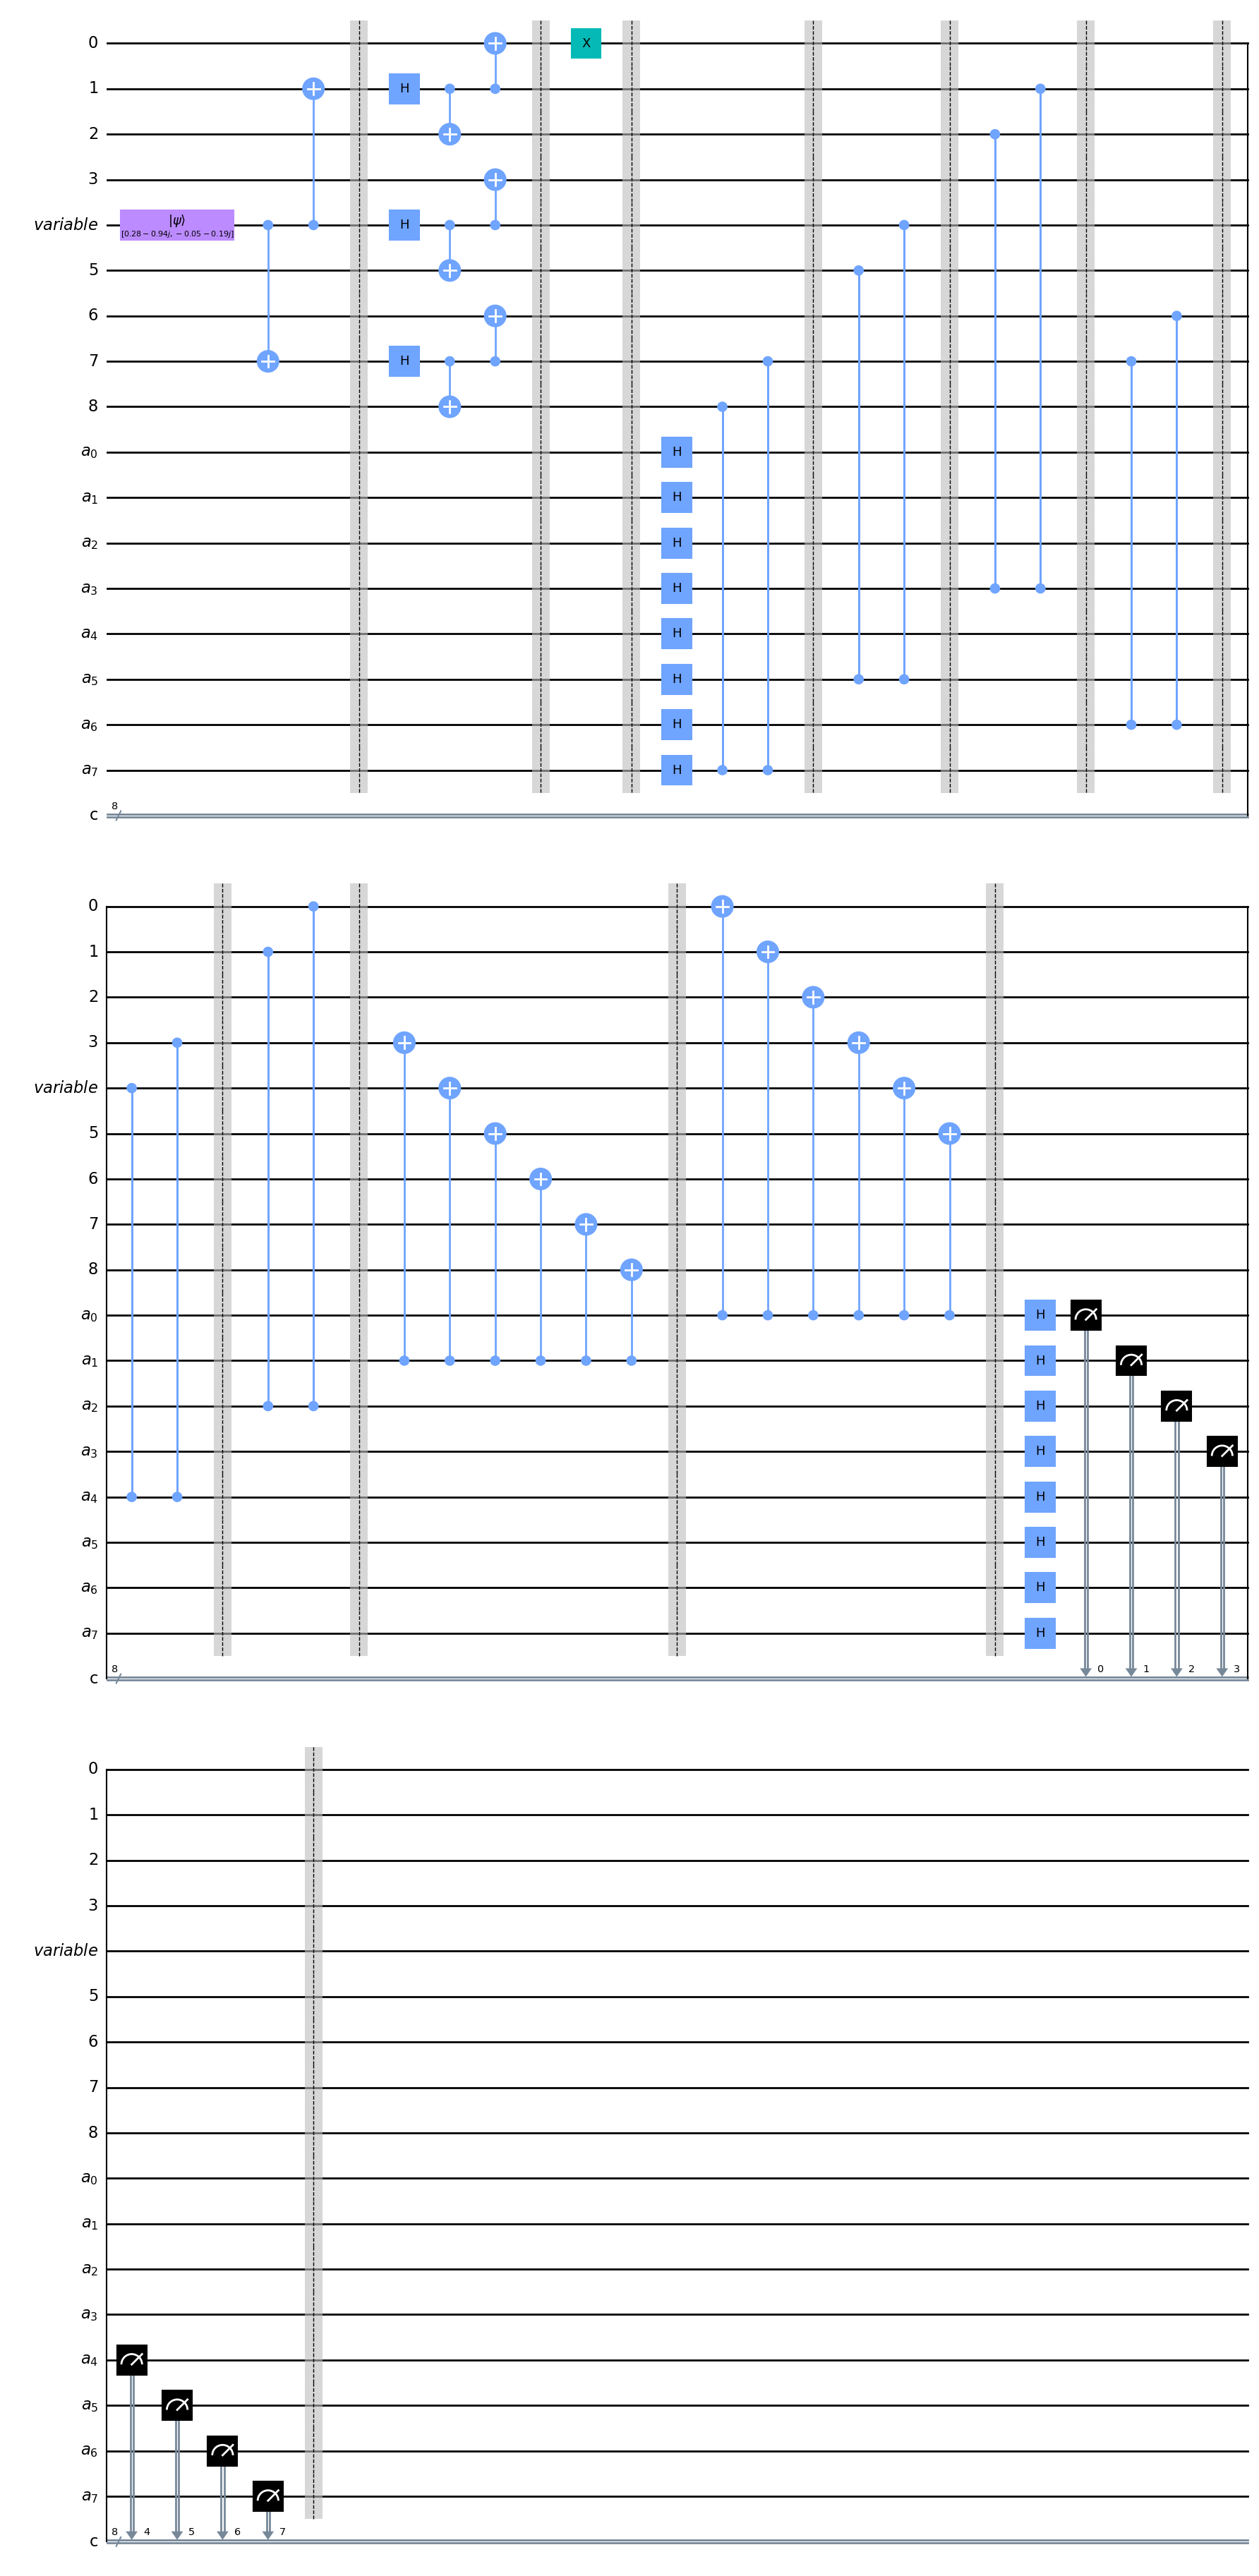

In [25]:
# Define Quantum Registers for circuit"
q_input = QuantumRegister(1, 'variable')
q = QuantumRegister(8, "q_")
a = QuantumRegister(8, "a")
c = ClassicalRegister(8, 'c')
circ = QuantumCircuit(q[:4], q_input, q[4:], a, c)

# Define a method to fastly use barrier :
def barrier():
    circ.barrier(q[:4],q_input,q[4:],a)

# Initialized qubit 4 with the previously random vector :
circ.initialize(random_vector,4)

# Circuit implementation :
circ.cx(q_input[0], q[6])
circ.cx(q_input[0], q[1])
barrier()
circ.h(q[1])
circ.h(q_input[0])
circ.h(q[6])
circ.cx(q[1], q[2])
circ.cx(q_input[0], q[4])
circ.cx(q[6], q[7])
circ.cx(q[1], q[0])
circ.cx(q_input[0], q[3])
circ.cx(q[6], q[5])
barrier()


errors = ["X", "Z", "XZ"]
# Chose a random error type for the qubit 0 :
error = errors[random.randint(0,2)]
if error=="X":
    circ.x(q[0])
    print("Introduced a X error on qubit_0")
if error=="Z":
    circ.z(q[0])
    print("Introduced a Z error on qubit_0")
if error=="XZ":
    circ.x(q[0])
    circ.z(q[0])
    print("Introduced a XZ error on qubit_0")
barrier()

# Hadamard gates on Ancilla qubits
for x in a:
    circ.h(x)

circ.cz(q[7],a[7])
circ.cz(q[6],a[7])
barrier()
circ.cz(q[4],a[5])
circ.cz(q_input[0],a[5])
barrier()
circ.cz(q[2],a[3])
circ.cz(q[1],a[3])
barrier()
circ.cz(q[6],a[6])
circ.cz(q[5],a[6])
barrier()
circ.cz(q_input[0],a[4])
circ.cz(q[3],a[4])
barrier()
circ.cz(q[1],a[2])
circ.cz(q[0],a[2])
barrier()
for i in range(3,9):
    circ.cx(a[1], i)
barrier()
for i in range(0,6):
    circ.cx(a[0], i)
barrier()
for i in range(8) :
    circ.h(a[i])
    circ.measure(a[i],c[i])
barrier()

circ.draw('mpl')

{'00000100': 1024}


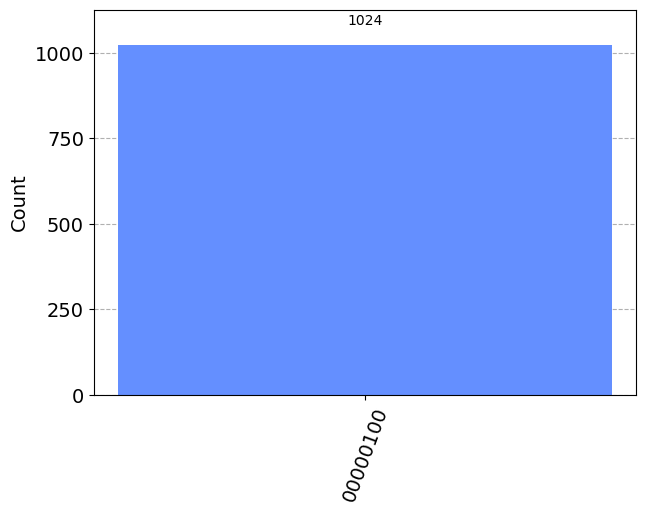

In [26]:
# Display measurements of ancilla qubits for 1024 shots

qc_compiled = transpile(circ, backend)
job_sim = backend.run(qc_compiled, shots=1024)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)
plot_histogram(counts)

ancilla =  00000100


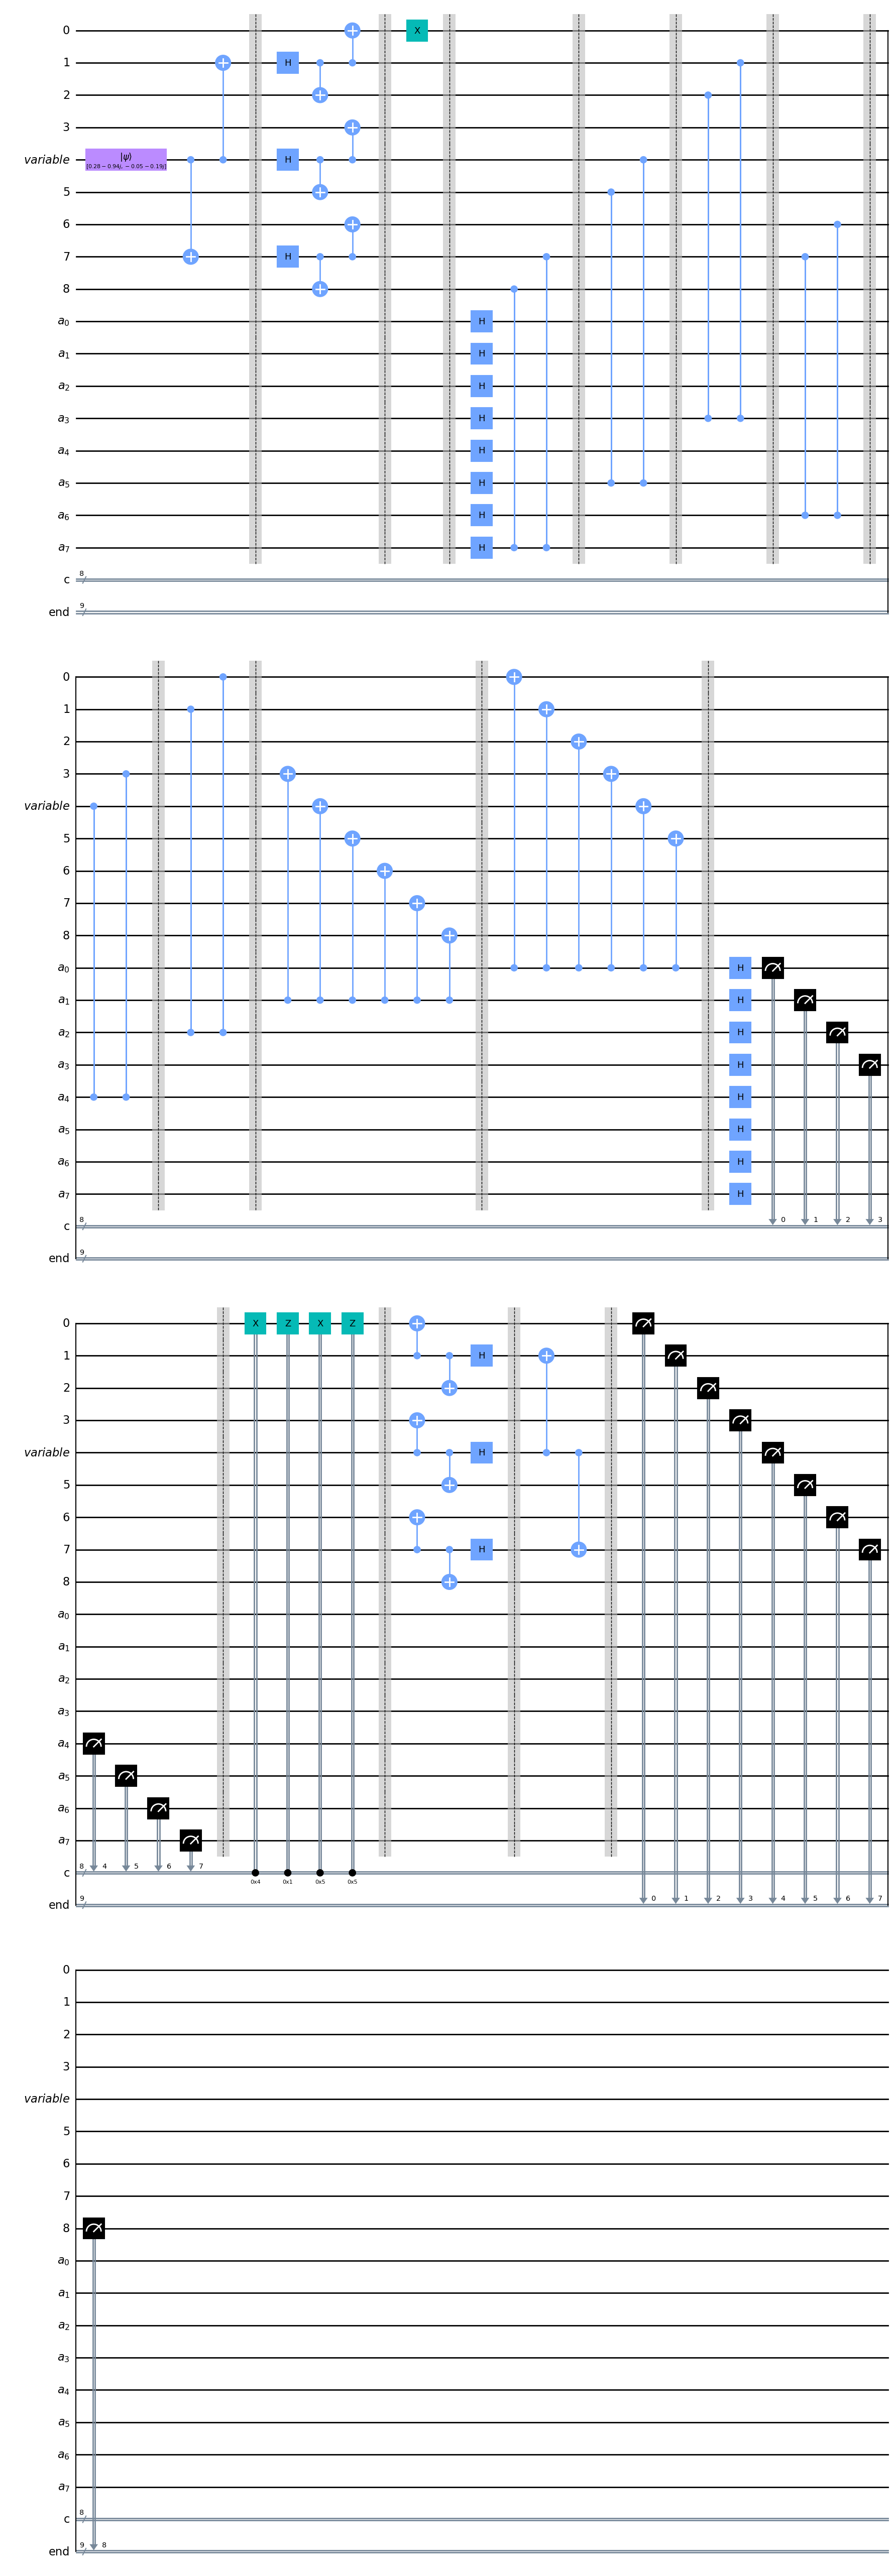

In [27]:
ancilla = max(counts)
print("ancilla = ", ancilla)

# Add a new Classical Register to get measurements of the 9 qubits
c_end = ClassicalRegister(9, 'end')

# Correct state according to the error :
"""if(ancilla=='00000100'):
    #Apply X error correction on line 0
    print("It was a X error on line 0.")
    circ.x(q[0])

if(ancilla=='00000001'):
    print("It was a Z error on line 0.")
    #Apply Z correction on line 0
    circ.z(q[0])

if(ancilla=='00000101'):
    print("It was XZ error on line 0.")
    #Apply X and Z correction on line 0
    circ.x(q[0])
    circ.z(q[0])"""

circ.x(q[0]).c_if(c,4)
circ.z(q[0]).c_if(c,1)
circ.x(q[0]).c_if(c,5)
circ.z(q[0]).c_if(c,5)
barrier()
circ.cx(q[1], q[0])
circ.cx(q_input[0], q[3])
circ.cx(q[6], q[5])
circ.cx(q[1], q[2])
circ.cx(q_input[0], q[4])
circ.cx(q[6], q[7])
circ.h(q[1])
circ.h(q_input[0])
circ.h(q[6])
barrier()
circ.cx(q_input[0], q[1])
circ.cx(q_input[0], q[6])
barrier()
circ.add_register(c_end)
for i in range(9) :
    circ.measure(i,c_end[i])



circ.draw('mpl')



{'000010000 00000100': 42, '000000000 00000100': 958}
P(M(q=0))=96.13%
P(M(q=1))=3.87%

  State    Initial (%)    After correction (%)
-------  -------------  ----------------------
      0          96.13                    95.8
      1           3.87                     4.2


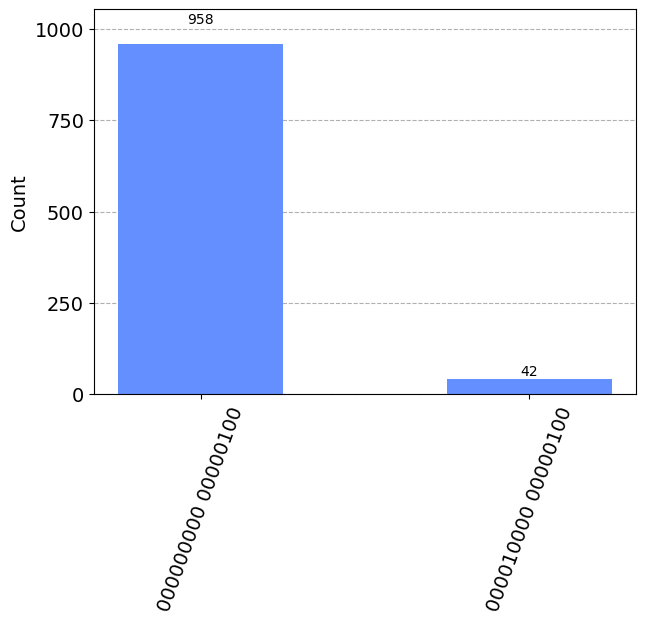

In [28]:
# Let's verify if we applied a good correction. In fact, if probabilities of our qubit 4 are the same as calculated in theory.
qc_compiled = transpile(circ, backend)
# Let's run 1000 shots
shots = 1000
job_sim = backend.run(qc_compiled, shots=shots)
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)
print(counts)

import re
for e in counts.keys():
    x = re.match("^000000000", e)
    if(x):
        corrected_p_0 = round(counts[e]*100/shots,2)
    else:
        corrected_p_1 = round(counts[e]*100/shots,2)

print("P(M(q=0))="+str(p_0)+"%")
print("P(M(q=1))="+str(p_1)+"%")

print("")
from tabulate import tabulate
data = [[0, p_0, corrected_p_0],
[1, p_1, corrected_p_1]]
print(tabulate(data, headers=["State", "Initial (%)", "After correction (%)"]))
plot_histogram(counts)
